In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from final_algo import our_algo, new_algo
from paper_sims_util import (confusion, MCC,
                             grid_graph, star, their_random_graph, their_random_graph_2,
                             attr_threshold, run_single_MTP)

In [3]:
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import GraphicalLasso

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [5]:
from collections import defaultdict

In [6]:
#TP, TN, FP, FN
#FP is when something should have been removed but was not
#FN is when something should not have been removed but was

In [38]:
p = 100

In [39]:
omega = their_random_graph_2(p, d=0.01)

In [40]:
### our random
# p = 30
#omega = random_graph(p, 0.1)
#omega = omega + np.eye(p) * (abs(np.real(sorted(np.linalg.eigvals(omega))[0])) + 0.2)

##grid graph
# p = 25
# omega = grid_graph(int(np.sqrt(p)))

##star graph
# p = 20
# omega = star(d = 2, p = p)

##their random
p = 100
omega = their_random_graph_2(p, d=0.05)
sigma = np.linalg.inv(omega)
#N = int(np.power(p, 1))
N = 100
X = np.random.multivariate_normal(mean = np.zeros(p), cov = np.linalg.inv(omega), size = N)

In [41]:
our_graph = new_algo(X) #our_algo(X)

N=100, M=50
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4


In [42]:
print(confusion(our_graph, omega))
print(MCC(our_graph, omega))

(29, 4857, 25, 39)
0.47214836019555795


In [43]:
glasso = GraphicalLassoCV(alphas = 10, n_refinements = 10, cv=5)
glasso.fit(np.cov(X.T))
glassocv_prec = glasso.get_precision()
print(confusion(glassocv_prec, omega))
print(MCC(glassocv_prec, omega))

(61, 2193, 2689, 7)
0.08111066169996027


In [44]:
print(glasso.cv_alphas_)
print(glasso.alpha_)

[0.003337721213744944, 0.002000911299595513, 0.001199514810392714, 0.0007190902368547427, 0.00043108327155253547, 0.00025842763187170815, 0.00015492329515431018, 0.00014116033659929475, 0.0001286200413500035, 0.00011719379136815742, 0.00010678261794263389, 9.729634446983753e-05, 9.647691973164873e-05, 9.632867657131493e-05, 9.618066119638958e-05, 9.603287325686575e-05, 9.588531240327352e-05, 9.573797828668074e-05, 9.56643961458643e-05, 9.564433810620237e-05, 9.562428427212777e-05, 9.560423464275836e-05, 9.559087055869067e-05, 9.55841892172127e-05, 9.556414799460936e-05, 9.556050458744115e-05, 9.555686131917877e-05, 9.555321818981689e-05, 9.554957519935024e-05, 9.554593234777352e-05, 9.554560118633535e-05, 9.55452700260448e-05, 9.554493886690224e-05, 9.554460770890747e-05, 9.55442765520603e-05, 9.554424644694924e-05, 9.554421634184786e-05, 9.554418623675576e-05, 9.554415613167316e-05, 9.554412602660024e-05, 9.554412328977596e-05, 9.554412055295158e-05, 9.554411781612746e-05, 9.554411507

In [46]:
MTP2_prec = run_single_MTP(np.cov(X.T))

In [47]:
for thres in [0.8, 0.9, 0.95, 0.99]:
    MTP2_tuned_prec = attr_threshold(MTP2_prec, thres)
    print(confusion(MTP2_tuned_prec, omega))
    print(MCC(MTP2_tuned_prec, omega))

(50, 4315, 571, 14)
0.22659340405979866
(51, 4238, 648, 13)
0.21548394133511842
(51, 4199, 687, 13)
0.2081499784679637
(51, 4168, 718, 13)
0.20268723253760706


In [62]:
import sklearn

In [69]:
model = GraphicalLasso(alpha=0.1)
model.fit(np.cov(X.T))
prec = model.get_precision()

In [88]:
def get_MCCs(omega, Ns):
    p, _ = omega.shape
    sigma = np.linalg.inv(omega)
    N_to_res = {}
    for N in Ns:
        results = {'glasso': {}, 'MTP2': {}}
        X = np.random.multivariate_normal(mean = np.zeros(p), cov = np.linalg.inv(omega), size = N)
        
        #our algo
        our_graph = new_algo(X, 0.95)
        results['our_algo'] = our_graph
        
        #glasso
        for alpha in[0.001,0.01,0.1,1]:
            try:
                glasso = GraphicalLasso(alpha, mode = 'lars')
                glasso.fit(np.cov(X.T))
                glasso_prec = glasso.get_precision()
                results['glasso'][alpha] = glasso_prec
            except:
                print('glasso had an error with alpha={}, N={}'.format(alpha, N))
                results['glasso'][alpha] = None
        
        #MTP2
        MTP2_prec = run_single_MTP(np.cov(X.T))
        for thres in [0.8, 0.9, 0.95, 0.99]:
            MTP2_tuned_prec = attr_threshold(MTP2_prec, thres)
            results['MTP2'][thres] = MTP2_tuned_prec
        
        #glasso cv
        glasso_cv = GraphicalLassoCV(alphas = 10, n_refinements = 10, cv=5, mode = 'lars')
        glasso_cv.fit(np.cov(X.T))
        glassocv_prec = glasso_cv.get_precision()
        results['glasso_cv'] = glassocv_prec
        
        N_to_res[N] = results
    return N_to_res

In [7]:
res, omega = pickle.load(open('new_algo_results/grid_graph.pkl', 'rb'))

In [8]:
res

{50: {'glasso': {0.001: array([[175.67941963, -14.65592715,  -1.88871174, ...,   0.        ,
            -0.5243452 ,   0.        ],
          [-14.65592715, 173.04755989, -13.35845943, ...,   0.        ,
             0.        ,   2.88390197],
          [ -1.88871174, -13.35845943, 170.91258278, ...,   0.        ,
            -0.31793534,   0.        ],
          ...,
          [  0.        ,   0.        ,   0.        , ..., 169.77978587,
            -2.52665047,  -1.2556536 ],
          [ -0.5243452 ,   0.        ,  -0.31793534, ...,  -2.52665047,
           183.48801569,  -0.        ],
          [  0.        ,   2.88390197,   0.        , ...,  -1.2556536 ,
            -0.        , 174.88406017]]),
   0.01: array([[43.33281884, -0.63441934, -0.        , ...,  0.        ,
           -0.        ,  0.        ],
          [-0.63441934, 74.79976878, -0.        , ..., -0.        ,
            0.        ,  0.        ],
          [-0.        , -0.        , 42.20924671, ...,  0.        ,
    

In [13]:
for N in res.keys():
    X = np.random.multivariate_normal(mean = np.zeros(100), cov = np.linalg.inv(omega), size = N)
    res[N]['our_algo_0.95'] = new_algo(X, 0.95)

Running new algorithm
N=50, M=41
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Running new algorithm
N=100, M=79
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 6
Running new algorithm
N=200, M=153
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 6
Working on l = 7
Running new algorithm
N=500, M=366
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 6
Working on l = 7
Working on l = 8
Running new algorithm
N=1000, M=707
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 6


In [16]:
pickle.dump((res, omega), open('new_algo_results/grid_graph_with_0.95.pkl', 'wb'))

defaultdict(<class 'list'>, {'glasso': [0.4001216014236023, 0.5122524986636834, 0.6460494664520271, 0.7332754585718183, 0.7221732080577193], 'MTP2': [0.5348682819464329, 0.63436962957841, 0.6481425693727225, 0.6234829093302654, 0.6438525600284845], 'our_algo': [0.39418911113601923, 0.7067720240161053, 0.8689840680017501, 0.9942348008385744, 1.0], 'glasso_cv': [0.2850526239483554, 0.5125895388541072, 0.6241847652523693, 0.6746259904661959, 0.6814648930700057], 'our_algo_2_3': [0.20987786888903517, 0.3265822187641321, 0.505725318413041, 0.7122295533080967, 0.8353455559241324], 'our_algo_0.95': [0.5147339889682194, 0.7558409415666043, 0.8746550540138835, 0.8800029830660155, 0.909419608957951]})


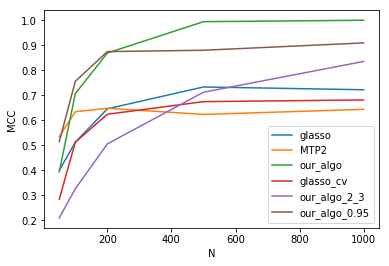

In [14]:
plot_curves(res, omega, '')

Running new algorithm
N=50, M=27
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4


/usr/local/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.101e-03
  % (max_iter, d_gap), ConvergenceWarning)


Running new algorithm
N=100, M=50
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4


/usr/local/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.435e-03
  % (max_iter, d_gap), ConvergenceWarning)


Running new algorithm
N=200, M=90
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Running new algorithm
N=500, M=196
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5


/usr/local/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:240: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/usr/local/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:242: RuntimeWarning: invalid value encountered in multiply
  * coefs)


Running new algorithm
N=1000, M=354
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4


/usr/local/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:240: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/usr/local/lib/python3.6/site-packages/sklearn/covariance/graph_lasso_.py:242: RuntimeWarning: invalid value encountered in multiply
  * coefs)


defaultdict(<class 'list'>, {'glasso': [0.4001216014236023, 0.5122524986636834, 0.6460494664520271, 0.7332754585718183, 0.7221732080577193], 'MTP2': [0.5348682819464329, 0.63436962957841, 0.6481425693727225, 0.6234829093302654, 0.6438525600284845], 'our_algo': [0.39418911113601923, 0.7067720240161053, 0.8689840680017501, 0.9942348008385744, 1.0], 'glasso_cv': [0.2850526239483554, 0.5125895388541072, 0.6241847652523693, 0.6746259904661959, 0.6814648930700057]})


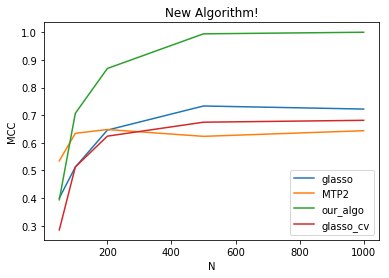

In [82]:
p = 100
omega = grid_graph(int(np.sqrt(p)))
res = get_MCCs(omega, [50, 100, 200, 500, 1000])
plot_curves(res, omega, "New Algorithm!")

In [83]:
pickle.dump((res, omega), open('new_algo_results/grid_graph.pkl', 'wb'))

In [86]:
res, omega = pickle.load(open('new_algo_results/random_graph_d_0.05.pkl', 'rb'))

defaultdict(<class 'list'>, {'glasso': [0.15249647204605385, 0.3127223067306986, 0.5011582265739909, 0.38409838961483195, 0.4208439042849691], 'MTP2': [0.21413903927006775, 0.2575662611393497, 0.23819857369730443, 0.22673958791340718, 0.22385903297245904], 'our_algo': [0.25602255969296694, 0.44744046060092135, 0.6909984177252075, 0.8201859652473729, 0.9143099036852578], 'glasso_cv': [0.05918466453270401, 0.08896562515455662, 0.16078469673653145, 0.7263181124600854, 0.77054003870127]})


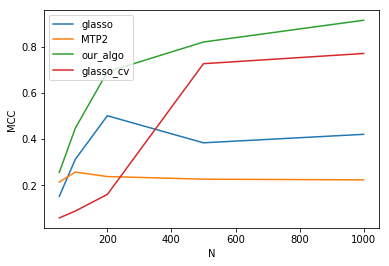

In [87]:
plot_curves(res, omega, '')

In [78]:
p = 100
omega = their_random_graph_2(p, d=0.02)

In [79]:
res = get_MCCs(omega, [50, 100, 200, 500, 1000])

Running new algorithm
N=50, M=27
Working on l = 0
Working on l = 1
Working on l = 2
Running new algorithm
N=100, M=50
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Running new algorithm
N=200, M=90
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Running new algorithm
N=500, M=196
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Running new algorithm
N=1000, M=354
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3


In [81]:
pickle.dump((res, omega), open('new_algo_results/random_graph_d_0.02.pkl', 'wb'))

defaultdict(<class 'list'>, {'glasso': [0.07906226854529783, 0.14230534707535505, 0.31984792839569687, 0.7443471260475854, 0.8502720864179344], 'MTP2': [0.13960082386053552, 0.15796032680739808, 0.1694488969978045, 0.15209424778876177, 0.13511101011858323], 'our_algo': [0.26544433641983356, 0.5187153433044908, 0.6387315458153495, 0.7201490108613476, 0.9489857416507816], 'glasso_cv': [0.04678771468045809, 0.04898229488231256, 0.11396601169750872, 0.5805739485311566, 0.8086060432453861]})


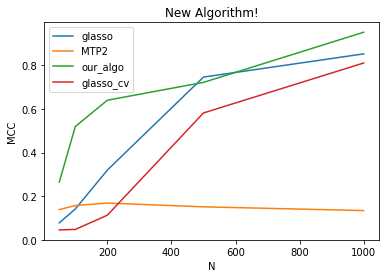

In [24]:
def get_MCCs_star(ds, p, N):
    ds_to_res = {}
    for d in ds:
        omega = star(d, p)
        ds_to_res[d] = get_MCCs(omega, [N])[N]
    return ds_to_res

In [28]:
p = 25
#omega = star_graph(d=2, p)
#res = get_MCCs(omega, [25, 50, 100, 625, 1025])
star_res = get_MCCs_star([2, 5, 7], p, 1000)

Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 3
Working on l = 4
Working on l = 5


In [29]:
def plot_curves_star(star_res, p, N):
    ds = star_res.keys()
    method_to_list = defaultdict(list)
    for d, results in star_res.items():
        for method, res in results.items():
            if type(res) == dict:
                sub_MCCs = []
                for par, prec in res.items():
                    if prec is not None:
                        sub_MCCs.append(MCC(prec, omega))
                if len(sub_MCCs) == 0:
                    method_to_list[method].append(0)
                else:
                    method_to_list[method].append(max(sub_MCCs))
            else:
                method_to_list[method].append(MCC(res, omega))
    print(method_to_list)
    for method, l in method_to_list.items():
        plt.plot(list(ds), l, label = method)
    plt.xlabel("d")
    plt.ylabel("MCC")
    title = "Star graph, p = {}, N = {}".format(p, N)
    plt.title(title)
    plt.legend()
    plt.show()

In [30]:
plot_curves_star(star_res, 25, 1000)

IndexError: index 25 is out of bounds for axis 1 with size 25

In [11]:
def plot_curves(N_to_res, omega, title):
    Ns = N_to_res.keys()
    method_to_list = defaultdict(list)
    for N, results in N_to_res.items():
        for method, res in results.items():
            if type(res) == dict:
                sub_MCCs = []
                for par, prec in res.items():
                    if prec is not None:
                        sub_MCCs.append(MCC(prec, omega))
                if len(sub_MCCs) == 0:
                    method_to_list[method].append(0)
                else:
                    method_to_list[method].append(max(sub_MCCs))
            else:
                method_to_list[method].append(MCC(res, omega))
    print(method_to_list)
    for method, l in method_to_list.items():
        plt.plot(list(Ns), l, label = method)
    plt.xlabel("N")
    plt.ylabel("MCC")
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
plot_curves(res, omega, 'Random graph, p = {}, density = 0.05'.format(p))

In [93]:
obj = (res, omega)

In [111]:
pickle.dump(star_res, open('star_p_25_N_1000.pkl', 'wb'))

In [97]:
res, omega = pickle.load(open('grid_graph_p_25.pkl', 'rb'))

defaultdict(<class 'list'>, {'glasso': [0.3716279616832767, 0.4606070005253964, 0.5505657271882287, 0.5851766927916734, 0.5424476379158709], 'MTP2': [0.6574527610297628, 0.6864064729836441, 0.7531983087525438, 0.7844645405527361, 0.7314487142543801], 'our_algo': [0, 0, 0.14744195615489714, 0.9855274566525744, 1.0]})


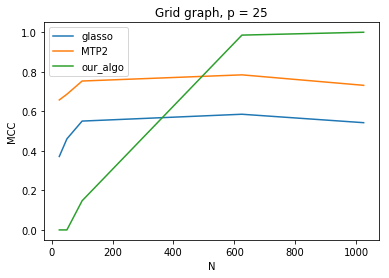

In [98]:
plot_curves(res, omega, 'Grid graph, p = {}'.format(p))